In [1]:
import os
import math
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoModel
from sklearn.preprocessing import MinMaxScaler
import joblib

import matplotlib.pyplot as plt
from IPython import display
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import CubicSpline

## Parameter

In [2]:
class Config:
    # I, V, t column names in excel
    INPUT_COLS = ["Current(A)", "Voltage(V)", "Time(s)"]
    TARGET_COLS = ["Voltage(V)", "SoC(%)"]

    OCV_FILE_PATH = '../Data/OCV20.xlsx'
    TRAIN_FILE_PATH = '../Data/20_FUDS.xlsx'
    Model_SAVE_DIR = "../Models/"

    SEQ_LEN = 6000
    TRAIN_SPLIT = 0.8

    # head dims
    INPUT_DIM = 3
    HEAD_DIM = 5

    EPOCHS = 5000
    BATCH_SIZE = 100
    LR = 1e-4
    WEIGHT_DECAY = 0.0

    # battery constants
    ETA = 1.08 # coulombic efficiency
    Q_Ah = 1.1 # rated capacity [Ah]

    # loss weights (paper: α=0.2 for voltage; β=1.0 for SOC dynamics)
    ALPHA = 0.2
    BETA = 1.0

cfg = Config()

In [3]:
#scaler_path = os.path.join(cfg.Model_SAVE_DIR, '20_US06_scaler.joblib')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load Data

In [5]:
class BatteryDataset(Dataset):

    def __init__(self, df: pd.DataFrame, seq_len: int, scaler: MinMaxScaler, config: "Config"):

        self.seq_len = seq_len
        self.scaler = scaler

        # 1. Clean the data
        df_clean = df.dropna(subset=[*config.INPUT_COLS, *config.TARGET_COLS])
        df_clean = df_clean[(df_clean[config.TARGET_COLS[1]] > 0.0) & (df_clean[config.TARGET_COLS[1]] < 1.0)]

        # 2. Extract and convert data to Tensor
        inputs_raw = df_clean.loc[:, config.INPUT_COLS].to_numpy(np.float32)
        model_inputs = df_clean.loc[:, config.INPUT_COLS].to_numpy(np.float32)
        targets = df_clean.loc[:, config.TARGET_COLS].to_numpy(np.float32)
        inputs_scaled = self.scaler.transform(model_inputs)

        self.scaled_data = torch.from_numpy(inputs_scaled)
        self.raw_data = torch.from_numpy(inputs_raw)
        self.target_data = torch.from_numpy(targets)

        n_samples = len(df_clean)

        #in my master thesis experiment, there is only one long sequence
        if n_samples >= self.seq_len:
            # Mode 1: Sequence length is sufficient, perform non-overlapping chunking and discard the remainder
            self.num_sequences = n_samples // self.seq_len
            self._mode = 'chunking'  # Set mode to "chunking"
        else:
            # Mode 2: Sequence length is insufficient, use the entire dataset as a single sequence
            self.num_sequences = 1 if n_samples > 0 else 0 # If empty after cleaning, number of sequences is 0
            self._mode = 'full'      # Set mode to "full"


    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx: int):

        if self._mode == 'chunking':
            start_idx = idx * self.seq_len
            end_idx = start_idx + self.seq_len

            scaled_inputs = self.scaled_data[start_idx:end_idx]
            raw_inputs = self.raw_data[start_idx:end_idx]
            targets = self.target_data[start_idx:end_idx]

        else: # self._mode == 'full'
            scaled_inputs = self.scaled_data
            raw_inputs = self.raw_data
            targets = self.target_data

        return scaled_inputs, raw_inputs, targets

In [6]:
full_df = pd.read_excel(cfg.TRAIN_FILE_PATH)

current_col = cfg.INPUT_COLS[0]  # "Current(A)"
full_df[current_col] = full_df[current_col] * -1 #Discharge is POSITIVE in paper!!! in Dataset usually negative 

full_df = full_df[(full_df[cfg.TARGET_COLS[1]] > 0.0) & (full_df[cfg.TARGET_COLS[1]] < 1.0)]
split_idx = int(len(full_df) * cfg.TRAIN_SPLIT)

train_df = full_df.iloc[:split_idx]
val_df = full_df.iloc[split_idx:]

print(f"Data split: {len(train_df)} for training, {len(val_df)} for validation.")

Data split: 6372 for training, 1594 for validation.


In [7]:
scaler = MinMaxScaler() #feature_range=(0, 1)
scaler.fit(train_df[cfg.INPUT_COLS])

#sequence_len = len(train_df)

train_dataset = BatteryDataset(train_df, cfg.SEQ_LEN, scaler, cfg)
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

val_dataset = BatteryDataset(val_df, cfg.SEQ_LEN, scaler, cfg)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)


C:\Users\Marven\.conda\envs\PINN\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Marven\.conda\envs\PINN\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## Model Structure

In [8]:
class PITransformer(nn.Module):
    def __init__(self, backbone: nn.Module, in_dim: int, out_dim: int):
        super().__init__()
        self.d_model = backbone.config.hidden_size
        self.in_proj = nn.Linear(in_dim, self.d_model)
        self.backbone = backbone

        # out_dim = 5, 5 outputs
        self.head = nn.Linear(self.d_model, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_proj(x)
        out = self.backbone(inputs_embeds=x).last_hidden_state

        output = self.head(out)


        R0 = torch.nn.functional.softplus(output[:, :, 0])
        R1 = torch.nn.functional.softplus(output[:, :, 1])
        C1 = torch.nn.functional.softplus(output[:, :, 2])
        SOC = 1.5 * torch.sigmoid(output[:, :, 3]) - 0.25
        Uoc = output[:, :, 4]

        y = torch.stack([R0, R1, C1, SOC, Uoc], dim=-1)  # (batch, seq_len, 5)

        return y

In [9]:
class Transformer(nn.Module):

    def __init__(self, backbone: nn.Module, in_dim: int):
        super().__init__()
        self.d_model = backbone.config.hidden_size
        self.in_proj = nn.Linear(in_dim, self.d_model)
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(self.d_model, 1),
            #nn.Sigmoid()
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_proj(x)
        out = self.backbone(inputs_embeds=x).last_hidden_state
        soc = self.head(out)
        return soc.squeeze(-1) # Shape: (B, L)

## Test and Visualization

In [10]:
transformer_config = AutoConfig.from_pretrained(
    "bert-base-uncased", # Use a standard config as a template
    max_position_embeddings=9000,

    # Increase model complexity for better performance on long sequences
    hidden_size=128,              # Model dimension
    num_hidden_layers=8,          # Number of encoder layers
    num_attention_heads=8,        # Number of attention heads
    intermediate_size=512         # Dimension of the FFN layer
)

# Initialize a model with this new configuration (random weights)
transformer_backbone = AutoModel.from_config(config=transformer_config)
pi_transformer_backbone = AutoModel.from_config(config=transformer_config)


In [11]:
PI_model_path = os.path.join(cfg.Model_SAVE_DIR, 'PIT_20_FUDS_model.pth')
Data_model_path = os.path.join(cfg.Model_SAVE_DIR, 'Transformer_20_FUDS_model.pth')


In [12]:
PI_model = PITransformer(
    backbone=pi_transformer_backbone,
    in_dim=cfg.INPUT_DIM,
    out_dim=cfg.HEAD_DIM
).to(device)

Data_model = Transformer(
    backbone=transformer_backbone,
    in_dim=cfg.INPUT_DIM,
    #out_dim=cfg.HEAD_DIM
).to(device)

PI_model.load_state_dict(torch.load(PI_model_path, map_location=device))
Data_model.load_state_dict(torch.load(Data_model_path, map_location=device))

<All keys matched successfully>

PI_SOC_RMSE: 0.0155 | PI_SOC_MAE: 0.0128 | DATA_SOC_RMSE: 0.0460 | DATA_SOC_MAE: 0.0432


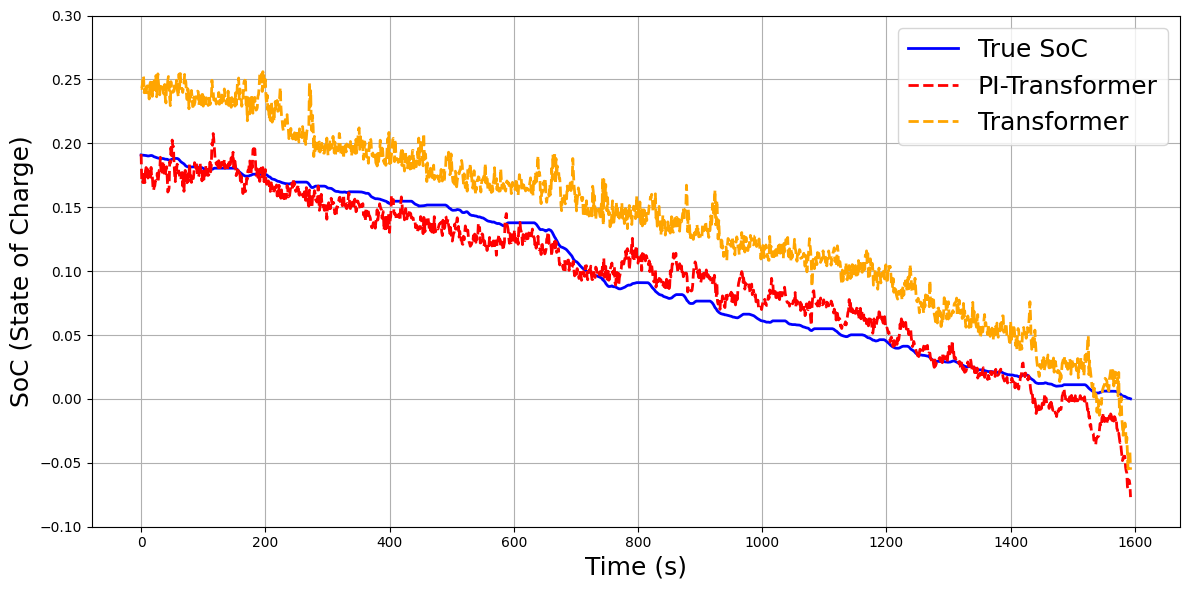

In [13]:
mse = nn.MSELoss()
PI_model.eval()
Data_model.eval()
pi_soc_preds, data_soc_preds, soc_trues = [], [], []
pi_all_soc_preds, data_all_soc_preds, all_soc_trues, pi_all_preds, data_all_preds, all_trues = None, None, None, None, None, None 


with torch.no_grad():

      for xs_scaled, xs_raw, ys in val_loader:
          xs_scaled, xs_raw, ys = xs_scaled.to(device), xs_raw.to(device), ys.to(device)
          pi_pred = PI_model(xs_scaled)
          data_pred = Data_model(xs_scaled)

          pi_soc_preds.append(pi_pred[..., 3].detach().cpu())
          data_soc_preds.append(data_pred.detach().cpu())
          soc_trues.append(ys[..., 1].cpu())

      pi_all_preds = torch.cat(pi_soc_preds).view(-1)
      data_all_preds = torch.cat(data_soc_preds).view(-1)
      all_trues = torch.cat(soc_trues).view(-1)

      pi_all_soc_preds = pi_all_preds.numpy()
      data_all_soc_preds = data_all_preds.numpy()
      all_soc_trues = all_trues.numpy()

      pi_soc_rmse = np.sqrt(np.mean((pi_all_soc_preds - all_soc_trues) ** 2))
      pi_soc_mae = np.mean(np.abs(pi_all_soc_preds - all_soc_trues))

      data_soc_rmse = np.sqrt(np.mean((data_all_soc_preds - all_soc_trues) ** 2))
      data_soc_mae = np.mean(np.abs(data_all_soc_preds - all_soc_trues))


print(f"PI_SOC_RMSE: {pi_soc_rmse:.4f} | PI_SOC_MAE: {pi_soc_mae:.4f} | DATA_SOC_RMSE: {data_soc_rmse:.4f} | DATA_SOC_MAE: {data_soc_mae:.4f}")


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(all_soc_trues, label='True SoC', color='blue', linewidth=2)
ax.plot(pi_all_soc_preds, label='PI-Transformer', color='red', linestyle='--', linewidth=2)
ax.plot(data_all_soc_preds, label='Transformer', color='orange', linestyle='--', linewidth=2)

#ax.set_title('Test Set: True vs. Predicted SoC', fontsize=18)
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('SoC (State of Charge)', fontsize=18)
ax.grid(True)
ax.legend(fontsize=18)
ax.set_ylim(-0.1, 0.3)

plt.tight_layout()

save_path = "../Plots/result_pit_vs_ddt_fuds_20c.pdf"
plt.savefig(save_path)


plt.show()
